In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


In [15]:
df = pd.read_csv(
    "/Users/tanmaysingh/Desktop/6th sem/predictive/Assignment - Learning Probability Density Functions using data only/data.csv",
    encoding="latin1"
)
x = df["no2"].dropna().values


/var/folders/k9/wy2l4y9s6h3dmp46vhkk6t2h0000gn/T/ipykernel_5561/1164683181.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [17]:
r = 102316072

a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

z = x + a_r * np.sin(b_r * x)
z = z.reshape(-1, 1)


In [19]:
z_mean = np.mean(z)
z_std = np.std(z)

z = (z - z_mean) / z_std


In [21]:
latent_dim = 5
epochs = 8000
batch_size = 64


In [23]:
generator = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_dim=latent_dim),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
discriminator = tf.keras.Sequential([
    layers.Dense(64, input_dim=1),
    layers.LeakyReLU(0.2),
    layers.Dense(64),
    layers.LeakyReLU(0.2),
    layers.Dense(32),
    layers.LeakyReLU(0.2),
    layers.Dense(1, activation='sigmoid')
])


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.0002, 0.5),
    metrics=['accuracy']
)


In [29]:
discriminator.trainable = False

gan_input = tf.keras.Input(shape=(latent_dim,))
fake_sample = generator(gan_input)
gan_output = discriminator(fake_sample)

gan = tf.keras.Model(gan_input, gan_output)

gan.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.0002, 0.5)
)


In [31]:
for epoch in range(epochs):

    idx = np.random.randint(0, z.shape[0], batch_size)
    real_samples = z[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_samples = generator.predict(noise, verbose=0)

    d_loss_real = discriminator.train_on_batch(real_samples, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((batch_size, 1)))

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 1000 == 0:
        print("Epoch:", epoch, "D Loss:", d_loss_real[0], "G Loss:", g_loss)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch: 0 D Loss: 0.7422941 G Loss: 0.70026475
Epoch: 1000 D Loss: 0.7194118 G Loss: 0.69382054
Epoch: 2000 D Loss: 0.71940833 G Loss: 0.69360167
Epoch: 3000 D Loss: 0.71942747 G Loss: 0.6935063
Epoch: 4000 D Loss: 0.7194679 G Loss: 0.69346863
Epoch: 5000 D Loss: 0.71948063 G Loss: 0.6934351
Epoch: 6000 D Loss: 0.7194742 G Loss: 0.69340175
Epoch: 7000 D Loss: 0.7195023 G Loss: 0.69339573


In [33]:
noise = np.random.normal(0, 1, (20000, latent_dim))
generated_samples = generator.predict(noise)


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


In [37]:
kde = gaussian_kde(generated_samples.flatten())

z_range = np.linspace(z.min(), z.max(), 1000)
pdf_estimate = kde(z_range.reshape(1, -1))


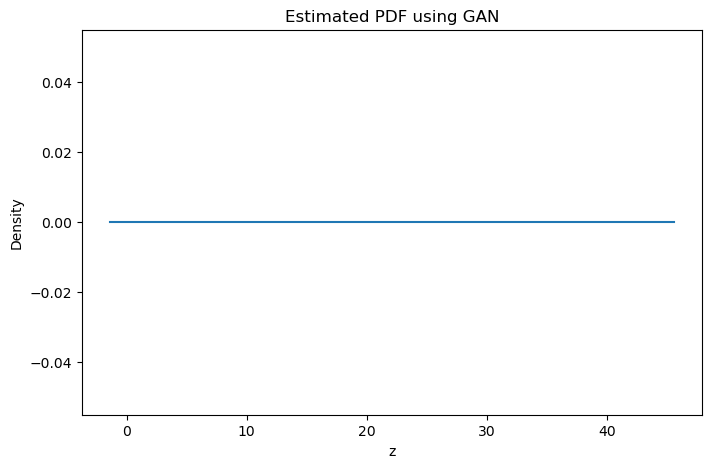

In [39]:
plt.figure(figsize=(8,5))
plt.plot(z_range, pdf_estimate)
plt.title("Estimated PDF using GAN")
plt.xlabel("z")
plt.ylabel("Density")
plt.show()


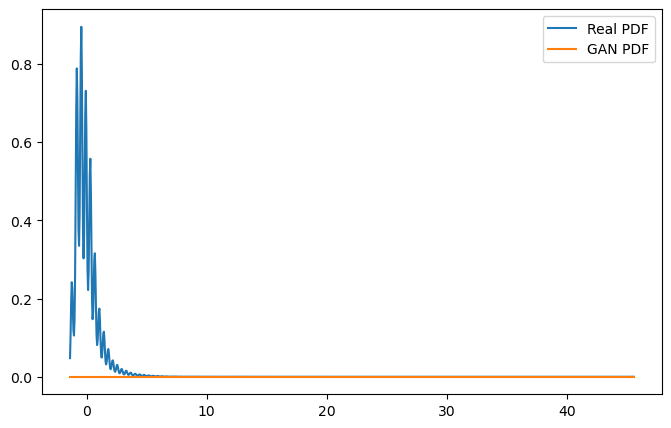

In [41]:
real_kde = gaussian_kde(z.flatten())

plt.figure(figsize=(8,5))
plt.plot(z_range, real_kde(z_range))
plt.plot(z_range, pdf_estimate)
plt.legend(["Real PDF", "GAN PDF"])
plt.show()
